In [2]:
import numpy as np
import scipy.sparse as sparse
import scipy.stats as stats
import json
from collections import defaultdict, Counter
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
colors = ['#695d46ff', '#ce93d8ff', '#ef6c00ff', '#4db6acff']


In [4]:
dataset = 'ihart.ms2'
data_dir = '../../DATA/ihart.ms2'
ped_file = '%s/ihart.ped' % data_dir

#dataset = 'ssc.hg38'
#data_dir = '../../DATA/ssc.hg38'
#ped_file = '../../DATA/ssc.hg38/ssc.ped'

chrom, start_pos, end_pos = '7', 4101620, 4747462 # (size=645842)
#chrom, start_pos, end_pos = '19', 3604269, 3718439 # (size=114170)

#chrom, start_pos, end_pos = '7', 4099839, 4870353 #(size=770,514)
#chrom, start_pos, end_pos = '19', 2935747, 4910913 #(size=1,975,166)
#chrom, start_pos, end_pos = '10', 86231469, 89247715 #(size=3,016,246)

In [5]:
gens = []
poss = []

for i in range(20):
    try:
        coords = np.load('%s/genotypes/chr.%s.%d.gen.coordinates.npy' % (data_dir, chrom, i))

        is_in_interval = ((coords[:, 1]>=start_pos) & (coords[:, 1]<=end_pos))
        is_snp = (coords[:, 2]==1)
        is_pass = (coords[:, 3]==1)

        to_include = (is_in_interval & is_snp & is_pass)
        print(i, np.sum(to_include))
        if np.sum(to_include):
            gen = sparse.load_npz('%s/genotypes/chr.%s.%d.gen.npz' % (data_dir, chrom, i))[:, to_include]
            pos = coords[to_include, 1]

            gens.append(gen)
            poss.append(pos)

            #with open('%s/genotypes/chr.%s.%d.gen.variants.txt' % (data_dir, chrom, i), 'r') as f, open('%s/genotypes/chr.%s.%d.gen.variants.subset.vcf' % (data_dir, chrom, i), 'w+') as outf:
            #    outf.write('#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\n')
            #    for line, include in zip(f, is_in_interval & is_snp & is_pass):
            #        if include:
            #            outf.write(line)
    except Exception as e: print(e)
                
print([gen.A.shape for gen in gens])
gen = np.hstack([gen.A for gen in gens])
pos = np.hstack(poss)
print(gen.shape, pos.shape)


0 20677
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
[Errno 2] No such file or directory: '../../DATA/ihart.ms2/genotypes/chr.7.16.gen.coordinates.npy'
[Errno 2] No such file or directory: '../../DATA/ihart.ms2/genotypes/chr.7.17.gen.coordinates.npy'
[Errno 2] No such file or directory: '../../DATA/ihart.ms2/genotypes/chr.7.18.gen.coordinates.npy'
[Errno 2] No such file or directory: '../../DATA/ihart.ms2/genotypes/chr.7.19.gen.coordinates.npy'
[(4610, 20677)]
(4610, 20677) (20677,)


In [6]:
with open('%s/genotypes/samples.json' % data_dir, 'r') as f:
    samples = json.load(f)
    sample_to_index = dict([(x, i) for i, x in enumerate(samples)])

trios = []
is_aut = []
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, f_id, m_id = pieces[0:4]
        phen = pieces[5]
        if f_id in sample_to_index and m_id in sample_to_index and child_id in sample_to_index:
            trios.append([sample_to_index[m_id], sample_to_index[f_id], sample_to_index[child_id]])
            is_aut.append(phen=='2')
trios = np.array(trios)
is_aut = np.array(is_aut)
num_trios = len(is_aut)
print(trios.shape)

(2293, 3)


In [7]:
gen_trios = gen[trios, :]

# trio, genomic position
gen_num = 9*gen_trios[:, 0, :] + 3*gen_trios[:, 1, :] + gen_trios[:, 2, :]
gen_num[(gen_trios[:, 0, :]==-1) | (gen_trios[:, 1, :]==-1) + (gen_trios[:, 2, :]==-1)] = -1


In [8]:
cons_to_pos = defaultdict(list)
gens_to_pos = defaultdict(list)
pos_to_snp = dict()

with open('../data/chr%s_VEP_%s.txt' % (chrom, dataset), 'r') as f:
    header = next(f).strip().split('\t')
    print(header)
    for line in f:
        pieces = line.strip().split('\t')
        sift = pieces[header.index('SIFT')]
        polyphen = pieces[header.index('PolyPhen')]
        p = int(pieces[1].split('-')[-1])
        if p >= start_pos and p <= end_pos:
            for cons in pieces[header.index('Consequence')].split(','):
                cons_to_pos[cons].append(p)
            if ('deleterious' in sift) or ('probably' in polyphen):
                cons_to_pos['DELETERIOUS'].append(p)
            if pieces[header.index('Existing_variation')] != '-':
                pos_to_snp[p] = pieces[header.index('Existing_variation')]
            if pieces[header.index('SYMBOL')] != '-':
                gens_to_pos[pieces[header.index('SYMBOL')]].append(p)

print(','.join(['%s: %d' % (k, len(v)) for k, v in cons_to_pos.items()]))

options = sorted([x for x, ps in cons_to_pos.items() if len(ps)>10])
pos_to_index = dict([(x, i) for i, x in enumerate(pos)])


['#Uploaded_variation', 'Location', 'Allele', 'Consequence', 'IMPACT', 'SYMBOL', 'Gene', 'Feature_type', 'Feature', 'BIOTYPE', 'EXON', 'INTRON', 'HGVSc', 'HGVSp', 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 'Existing_variation', 'DISTANCE', 'STRAND', 'FLAGS', 'SYMBOL_SOURCE', 'HGNC_ID', 'MANE_SELECT', 'MANE_PLUS_CLINICAL', 'TSL', 'APPRIS', 'SIFT', 'PolyPhen', 'AF', 'CLIN_SIG', 'SOMATIC', 'PHENO', 'PUBMED', 'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE', 'TRANSCRIPTION_FACTORS']
intron_variant: 19770,regulatory_region_variant: 2911,TF_binding_site_variant: 515,missense_variant: 140,DELETERIOUS: 77,synonymous_variant: 134,splice_polypyrimidine_tract_variant: 48,splice_region_variant: 30,upstream_gene_variant: 1605,downstream_gene_variant: 1782,non_coding_transcript_exon_variant: 360,non_coding_transcript_variant: 6391,splice_donor_variant: 3,splice_acceptor_variant: 4,3_prime_UTR_variant: 152,intergenic_variant: 11858,coding_sequence_var

In [9]:
# family-wise permute
num_trials=10000
trans_perm = np.random.randint(2, size=(num_trios, num_trials+1))
trans_perm[:, 0] = 0

aut_with_replacement = np.random.choice(np.where(is_aut)[0], size=(np.sum(is_aut), num_trials+1), replace=True)
aut_with_replacement[:, 0] = np.where(is_aut)[0]
nt_with_replacement = np.random.choice(np.where(~is_aut)[0], size=(np.sum(~is_aut), num_trials+1), replace=True)
nt_with_replacement[:, 0] = np.where(~is_aut)[0]

trio_indices = np.tile(np.arange(num_trios), (num_trials+1, 1)).T
print(trio_indices.shape)


(2293, 10001)


In [10]:
use_pat = 1

def perm_test(info):
    # info has children, trans/notrans
    aut_trans_trials = np.sum(info[trio_indices[is_aut, :], trans_perm[is_aut, :]], axis=0)
    aut_notrans_trials = np.sum(info[trio_indices[is_aut, :], 1-trans_perm[is_aut, :]], axis=0)
    
    nt_trans_trials = np.sum(info[trio_indices[~is_aut, :], trans_perm[~is_aut, :]], axis=0)
    nt_notrans_trials = np.sum(info[trio_indices[~is_aut, :], 1-trans_perm[~is_aut, :]], axis=0)
    
    aut_trans_rate_trials = aut_trans_trials/(aut_trans_trials+aut_notrans_trials)
    nt_trans_rate_trials = nt_trans_trials/(nt_trans_trials+nt_notrans_trials)
        
    return aut_trans_rate_trials[0], nt_trans_rate_trials[0], \
           np.sum((aut_trans_rate_trials[1:]-nt_trans_rate_trials[1:])>=(aut_trans_rate_trials[0]-nt_trans_rate_trials[0]))/num_trials

def bootstrap_conf_interval(info):
    aut_trans_trials = np.sum(info[aut_with_replacement, 0], axis=0)
    aut_notrans_trials = np.sum(info[aut_with_replacement, 1], axis=0)
    
    nt_trans_trials = np.sum(info[nt_with_replacement, 0], axis=0)
    nt_notrans_trials = np.sum(info[nt_with_replacement, 1], axis=0)
    
    aut_trans_rate_trials = aut_trans_trials/(aut_trans_trials+aut_notrans_trials)
    nt_trans_rate_trials = nt_trans_trials/(nt_trans_trials+nt_notrans_trials)

    return aut_trans_rate_trials[0], np.quantile(aut_trans_rate_trials[1:], [0.05, 0.95]), \
           nt_trans_rate_trials[0], np.quantile(nt_trans_rate_trials[1:], [0.05, 0.95])
           

# variant type, child, mat/pat, trans/notrans
info = np.zeros((len(options), len(is_aut), 2, 2))
pvalues = np.ones((len(options),))
aut_transrate = np.ones((len(options),))
aut_transrate_conf_int = np.ones((len(options), 2))
nt_transrate = np.ones((len(options),))
nt_transrate_conf_int = np.ones((len(options), 2))

for j, opt in enumerate(options):
    print(opt)
    indices = [pos_to_index[p] for p in cons_to_pos[opt]]
    
    info[j, :, 0, 0] += np.sum(gen_num[:, indices] == 9+0+1, axis=1) # (1, 0, 1)
    info[j, :, 0, 0] += np.sum(gen_num[:, indices] == 9+3+2, axis=1) # (1, 1, 2)
    info[j, :, 0, 0] += np.sum(gen_num[:, indices] == 9+6+2, axis=1) # (1, 2, 2)
    
    info[j, :, 0, 1] += np.sum(gen_num[:, indices] == 9+0+0, axis=1) # (1, 0, 0)
    info[j, :, 0, 1] += np.sum(gen_num[:, indices] == 9+3+0, axis=1) # (1, 1, 0)
    info[j, :, 0, 1] += np.sum(gen_num[:, indices] == 9+6+1, axis=1) # (1, 2, 1)
    
    info[j, :, 1, 0] += np.sum(gen_num[:, indices] == 0+3+1, axis=1) # (0, 1, 1)
    info[j, :, 1, 0] += np.sum(gen_num[:, indices] == 9+3+2, axis=1) # (1, 1, 2)
    info[j, :, 1, 0] += np.sum(gen_num[:, indices] == 18+3+2, axis=1) # (2, 1, 2)
    
    info[j, :, 1, 1] += np.sum(gen_num[:, indices] == 0+3+0, axis=1) # (0, 1, 0)
    info[j, :, 1, 1] += np.sum(gen_num[:, indices] == 9+3+0, axis=1) # (1, 1, 0)
    info[j, :, 1, 1] += np.sum(gen_num[:, indices] == 18+3+1, axis=1) # (2, 1, 1)
    
    atr, ntr, pvalues[j] = perm_test(info[j, :, use_pat, :])
    
    aut_transrate[j], aut_transrate_conf_int[j, :], \
    nt_transrate[j], nt_transrate_conf_int[j, :] = bootstrap_conf_interval(info[j, :, use_pat, :])

    assert atr==aut_transrate[j]
    assert ntr==nt_transrate[j]
    
pvalues = pvalues*len(options)


3_prime_UTR_variant
DELETERIOUS
TF_binding_site_variant
downstream_gene_variant
intergenic_variant
intron_variant
missense_variant
non_coding_transcript_exon_variant
non_coding_transcript_variant
regulatory_region_variant
splice_polypyrimidine_tract_variant
splice_region_variant
synonymous_variant
upstream_gene_variant


In [11]:
print(pvalues)

[4.49540e+00 1.14506e+01 1.03796e+01 3.18220e+00 9.64040e+00 8.59180e+00
 9.36320e+00 1.01052e+01 1.08696e+01 1.09410e+01 7.00000e-03 1.40000e-03
 9.32680e+00 7.59920e+00]


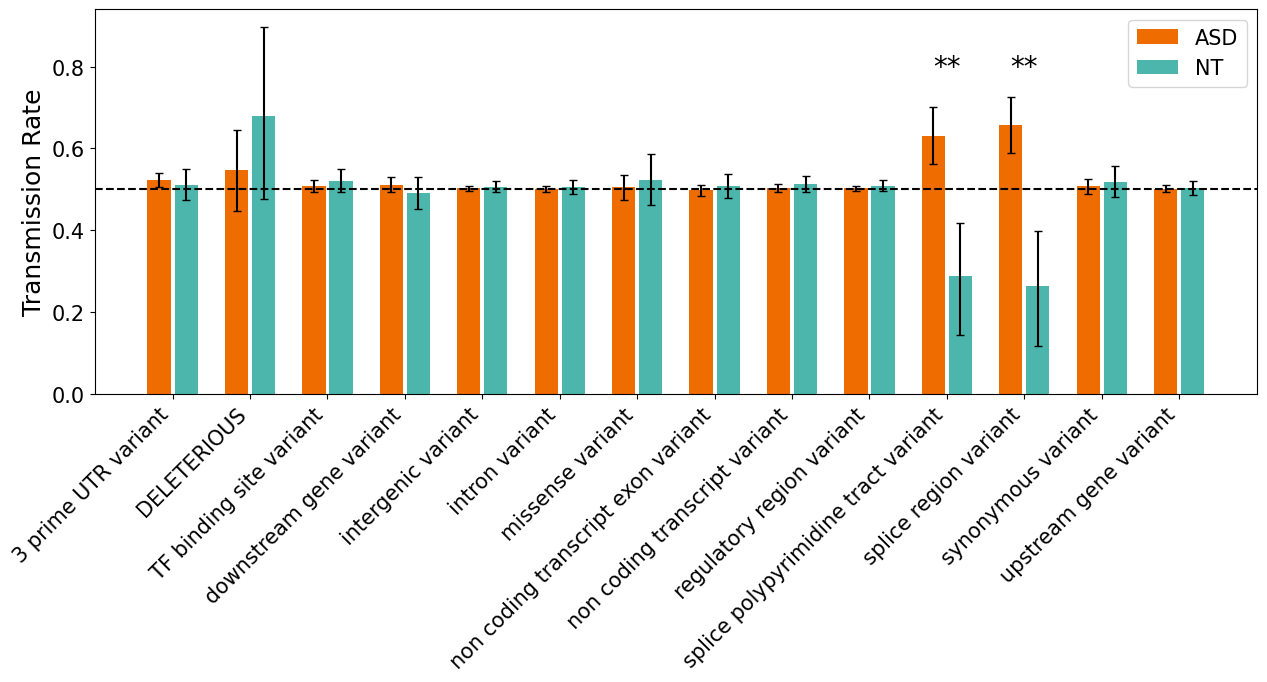

In [14]:
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(options)), aut_transrate, width=0.3, color=colors[2], label='ASD')
plt.bar(np.arange(len(options))+0.35, nt_transrate, width=0.3, color=colors[3], label='NT')
#plt.fill_between(np.arange(len(options)), aut_transrate_conf_int[:, 0], aut_transrate_conf_int[:, 1], alpha=0.5)
plt.errorbar(np.arange(len(options)), aut_transrate, 
             yerr=(aut_transrate_conf_int[:, 1]-aut_transrate, 
            aut_transrate-aut_transrate_conf_int[:, 0]), color='black', linestyle='', capsize=3)
plt.errorbar(np.arange(len(options))+0.35, nt_transrate, 
             yerr=(nt_transrate_conf_int[:, 1]-nt_transrate, 
            nt_transrate-nt_transrate_conf_int[:, 0]), color='black', linestyle='', capsize=3)
plt.axhline(0.5, color='black', linestyle='--')
plt.xticks(np.arange(len(options))+0.175, [x.replace('_', ' ') for x in options], fontsize=15, rotation=45, ha='right')
plt.yticks(fontsize=15)
plt.ylabel('Transmission Rate', fontsize=18)

for i in np.where(pvalues<0.05)[0]:
    plt.text(i+0.175, 0.8, '***' if pvalues[i]<0.001 else '**' if pvalues[i]<0.01 else '*', fontsize=20, ha='center', va='center')

plt.legend(fontsize=15)
plt.savefig('../plots/transrate_chr%s_%s.png' % (chrom, 'pat' if use_pat==1 else 'mat'), bbox_inches="tight")

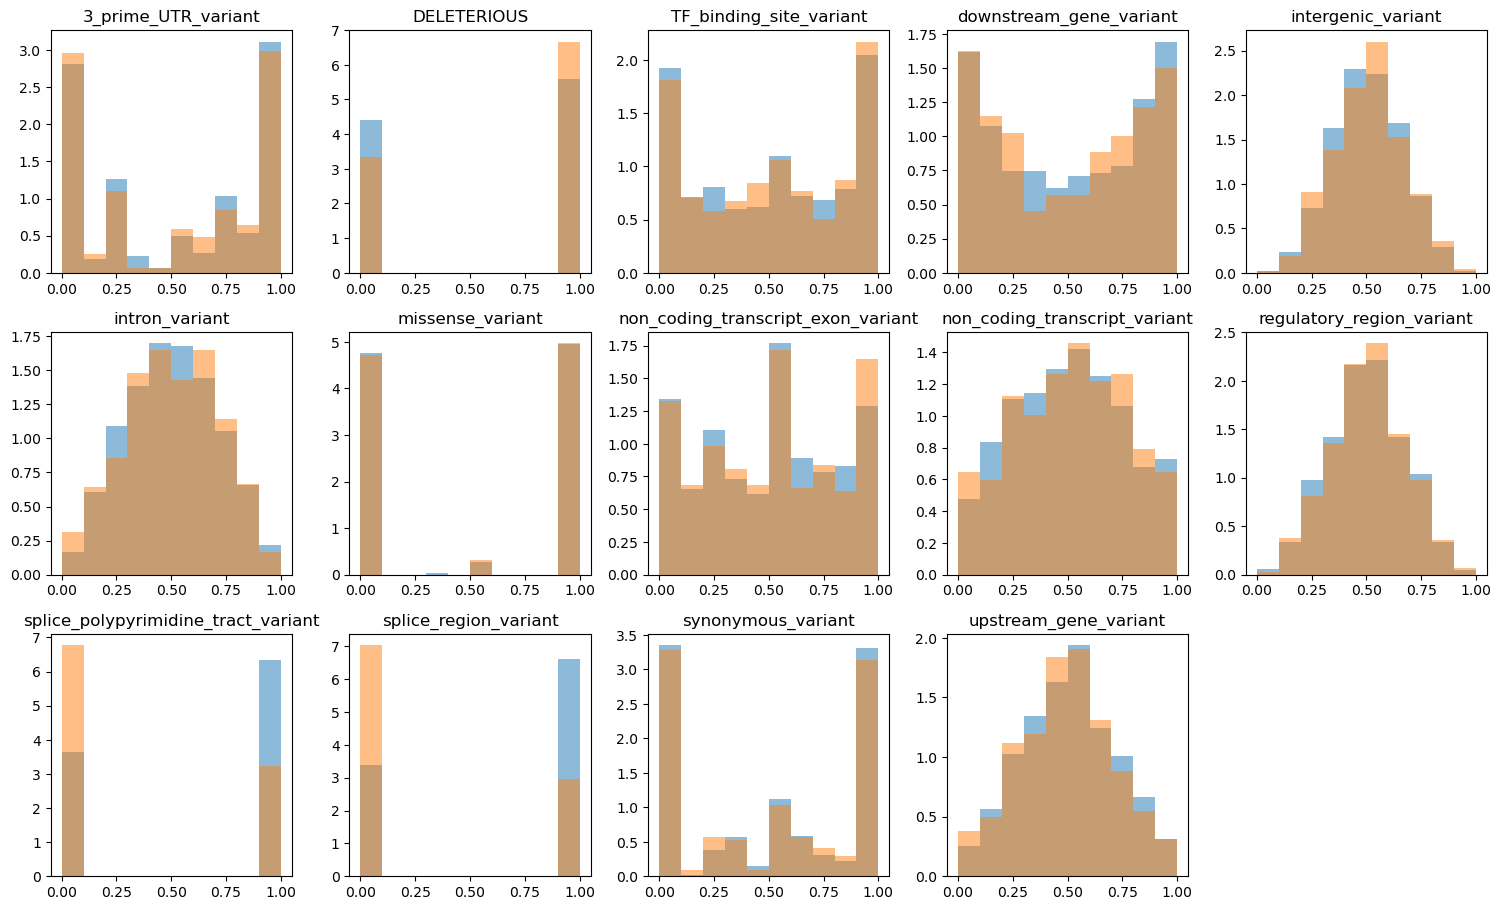

In [664]:
# make sure there aren't any extremes

options_with_data = [x for i, x in enumerate(options) if np.any(np.sum(info[i, is_aut, 1, :], axis=1)>0) and np.any(np.sum(info[i, ~is_aut, 1, :], axis=1)>0)]

plt.figure(figsize=(15, 15))
for i, opt in enumerate(options_with_data):
    plt.subplot(5, 5, i+1)
    plt.title(opt)
    
    has_data = np.sum(info[i, :, 1, :], axis=1)>0
    if np.any(has_data & is_aut) and np.any(has_data & ~is_aut):
        plt.hist(info[i, has_data & is_aut, 1, 0]/np.sum(info[i, has_data & is_aut, 1, :], axis=1), alpha=0.5, bins=np.arange(0, 1.1, 0.1), density=True)
        plt.hist(info[i, has_data & ~is_aut, 1, 0]/np.sum(info[i, has_data & ~is_aut, 1, :], axis=1), alpha=0.5, bins=np.arange(0, 1.1, 0.1), density=True)
    
    #has_any_mat = (info[i, :, 0, 0]>0) | (info[i, :, 0, 1]>0)
    #has_any_pat = (info[i, :, 1, 0]>0) | (info[i, :, 1, 1]>0)
    #if (np.sum(has_any_mat)>0) and (np.sum(has_any_pat)>0):
    #    #plt.violinplot([info[i, has_any_mat & is_aut, 0, 0]/(info[i, has_any_mat & is_aut, 0, 0]+info[i, has_any_mat & is_aut, 0, 1]), 
    #    #                info[i, has_any_mat & ~is_aut, 0, 0]/(info[i, has_any_mat & ~is_aut, 0, 0]+info[i, has_any_mat & ~is_aut, 0, 1]), 
    ##    #                info[i, has_any_pat & is_aut, 1, 0]/(info[i, has_any_pat & is_aut, 1, 0]+info[i, has_any_pat & is_aut, 1, 1]), 
    #    #                info[i, has_any_pat & ~is_aut, 1, 0]/(info[i, has_any_pat & ~is_aut, 1, 0]+info[i, has_any_pat & ~is_aut, 1, 1]), ],
    #    #              showmedians=True, showextrema=False)

    
plt.tight_layout()
plt.show()
    

In [448]:


c = Counter(zip(info[options.index('splice_region_variant'), is_aut, 1, 0], info[options.index('splice_region_variant'), is_aut, 1, 1]))
d = Counter(zip(info[options.index('splice_region_variant'), ~is_aut, 1, 0], info[options.index('splice_region_variant'), ~is_aut, 1, 1]))
print(c)
print(d)
#plt.scatter(info[options.index('splice_region_variant'), is_aut, 1, 0], 
#            info[options.index('splice_region_variant'), is_aut, 1, 1])
#plt.scatter(info[options.index('splice_region_variant'), ~is_aut, 1, 0], 
#            info[options.index('splice_region_variant'), ~is_aut, 1, 1])

aut_inherit = c[(1, 0)]+c[(3, 0)]+c[(4, 0)]
aut_noinherit = c[(0, 1)]+c[(0, 3)]+c[(0, 4)]
nt_inherit = d[(1, 0)]+d[(3, 0)]+d[(4, 0)]
nt_noinherit = d[(0, 1)]+d[(0, 3)]+d[(0, 4)]

print(stats.chi2_contingency([[aut_inherit, aut_noinherit], [nt_inherit, nt_noinherit]]))
print(aut_inherit/(aut_inherit+aut_noinherit), nt_inherit/(nt_inherit+nt_noinherit))
#plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

plt.show()

Counter({(0.0, 0.0): 1741, (3.0, 0.0): 63, (0.0, 3.0): 37, (4.0, 0.0): 16, (1.0, 0.0): 9, (0.0, 4.0): 6, (0.0, 1.0): 2})
Counter({(0.0, 0.0): 392, (0.0, 3.0): 15, (3.0, 0.0): 7, (0.0, 4.0): 4, (1.0, 0.0): 1})
Chi2ContingencyResult(statistic=11.007147498375568, pvalue=0.0009076121510156357, dof=1, expected_freq=array([[79.8, 53.2],
       [16.2, 10.8]]))
0.6616541353383458 0.2962962962962963


In [449]:
# TDT

c = np.zeros((gen_num.shape[1], 2, 2), dtype=int)
# maternal transmission
if chrom == '19':
    print('maternal transmission')
    c[:, 1, 0] += np.sum(gen_num[is_aut] == 9+0+1, axis=0) # (1, 0, 1)
    c[:, 1, 0] += np.sum(gen_num[is_aut] == 9+3+2, axis=0) # (1, 1, 2)
    c[:, 1, 0] += np.sum(gen_num[is_aut] == 9+6+2, axis=0) # (1, 2, 2)

    c[:, 1, 1] += np.sum(gen_num[is_aut] == 9+0+0, axis=0) # (1, 0, 0)
    c[:, 1, 1] += np.sum(gen_num[is_aut] == 9+3+0, axis=0) # (1, 1, 0)
    c[:, 1, 1] += np.sum(gen_num[is_aut] == 9+6+1, axis=0) # (1, 2, 1)

    c[:, 0, 0] += np.sum(gen_num[~is_aut] == 9+0+1, axis=0) # (1, 0, 1)
    c[:, 0, 0] += np.sum(gen_num[~is_aut] == 9+3+2, axis=0) # (1, 1, 2)
    c[:, 0, 0] += np.sum(gen_num[~is_aut] == 9+6+2, axis=0) # (1, 2, 2)

    c[:, 0, 1] += np.sum(gen_num[~is_aut] == 9+0+0, axis=0) # (1, 0, 0)
    c[:, 0, 1] += np.sum(gen_num[~is_aut] == 9+3+0, axis=0) # (1, 1, 0)
    c[:, 0, 1] += np.sum(gen_num[~is_aut] == 9+6+1, axis=0) # (1, 2, 1)

# paternal transmission
if chrom == '7':
    print('paternal transmission')
    c[:, 1, 0] += np.sum(gen_num[is_aut] == 0+3+1, axis=0) # (0, 1, 1)
    c[:, 1, 0] += np.sum(gen_num[is_aut] == 9+3+2, axis=0) # (1, 1, 2)
    c[:, 1, 0] += np.sum(gen_num[is_aut] == 18+3+2, axis=0) # (2, 1, 2)
    
    c[:, 1, 1] += np.sum(gen_num[is_aut] == 0+3+0, axis=0) # (0, 1, 0)
    c[:, 1, 1] += np.sum(gen_num[is_aut] == 9+3+0, axis=0) # (1, 1, 0)
    c[:, 1, 1] += np.sum(gen_num[is_aut] == 18+3+1, axis=0) # (2, 1, 1)#
    
    c[:, 0, 0] += np.sum(gen_num[~is_aut] == 0+3+1, axis=0) # (0, 1, 1)
    c[:, 0, 0] += np.sum(gen_num[~is_aut] == 9+3+2, axis=0) # (1, 1, 2)
    c[:, 0, 0] += np.sum(gen_num[~is_aut] == 18+3+2, axis=0) # (2, 1, 2)#
    
    c[:, 0, 1] += np.sum(gen_num[~is_aut] == 0+3+0, axis=0) # (0, 1, 0)
    c[:, 0, 1] += np.sum(gen_num[~is_aut] == 9+3+0, axis=0) # (1, 1, 0)
    c[:, 0, 1] += np.sum(gen_num[~is_aut] == 18+3+1, axis=0) # (2, 1, 1)



paternal transmission


In [450]:
indices = np.array([pos_to_index[p] for p in cons_to_pos['splice_region_variant']])

var_pvalues = np.ones((gen_num.shape[1], ))
num_tests = 0
for i in indices:
    if np.sum(c[i, :, :])>10:
        try:
            var_pvalues[i] = stats.chi2_contingency(c[i, :, :])[1]
            #var_pvalues[i, 0] = stats.binom_test(c[i, 1, 0], c[i, 1, 0]+c[i, 1, 1], alternative='greater')
            #var_pvalues[i, 1] = stats.binom_test(c[i, 0, 0], c[i, 0, 0]+c[i, 0, 1])
            num_tests += 1
        except:
            pass

In [451]:
print(c[np.where(var_pvalues < 0.05/num_tests)[0], :, :])
print(num_tests)

[]
7


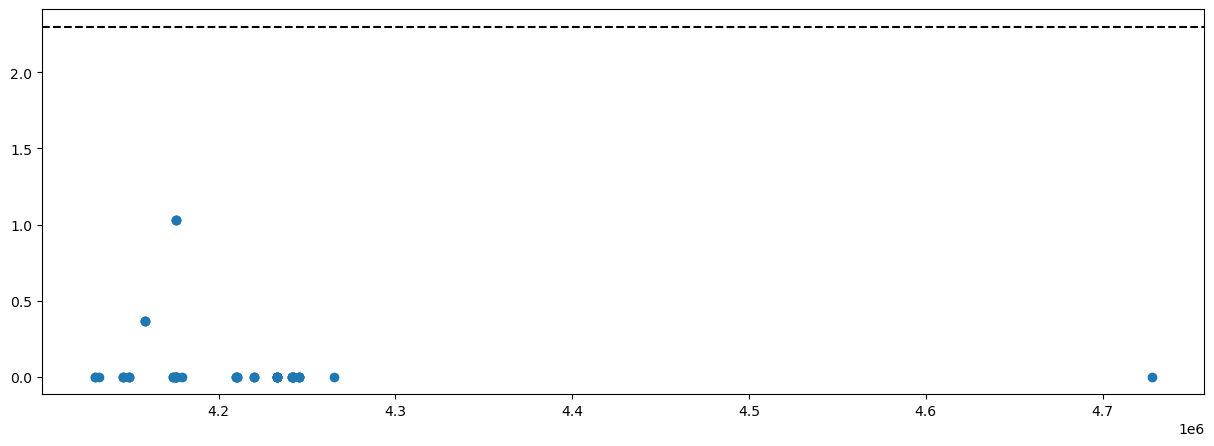

In [437]:

plt.figure(figsize=(15, 5))
plt.scatter(pos[indices], -np.log10(var_pvalues[indices]))
plt.axhline(-np.log10(0.05/num_tests), color='black', linestyle='--')
plt.show()

In [438]:
print(len(set(cons_to_pos['splice_region_variant']) & set(gens_to_pos['SDK1']))/len(set(cons_to_pos['splice_region_variant'])))



0.95


In [439]:
print(gens_to_pos.keys())

dict_keys(['SDK1', 'CYP3A54P', 'FOXK1'])
